In [1]:
from googlefinance import getQuotes
from yahoo_finance_api2 import share
import json
import datetime
import pandas as pd
# import pandas_datareader as web
# from pandas_datareader import data, wb

import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yfin
import matplotlib.pyplot as plt


In [6]:
### Query Period and timeframe
START = dt.datetime(2020, 1, 1) #dt.datetime(2005, 1, 1)
END = dt.datetime.today()
INTERVAL = '1d' #'1wk'

### TODO: Get this data from holdings.googlesheet directly

NSE_BSE = {
            'BAJFINANCE': 'BAJFINANCE.BO',
            'DMART': 'DMART.NS',
            'DEEPAKNTR': 'DEEPAKNI.BO',
            'SONACOMS': 'SONACOMS.BO',
            'POLYCAB': 'POLYCAB.BO',
            'FINEORG': 'FINEORG.BO',
            'KPITTECH': 'KPITTECH.BO',
            'DIVISLAB': 'DIVISLAB.BO',
            'NAUKRI': 'NAUKRI.BO',
            'AFFLE': 'AFFLE.BO',
            'HAPPSTMNDS': 'HAPPSTMNDS.BO',
            'TATACHEM': 'TATACHEM.BO',
            'RAJRATAN': 'RAJGLOWIR.BO',
            'PRINCEPIPE': 'PRINCEPIPE.BO',
            'IONEXCHANG': 'IONEXCHANG.BO',
            'BERGEPAINT': 'BERGEPAINT.BO',
            'RELAXO': 'RELAXO.BO',
            'DIXON': 'DIXON.BO',
            'PRAJIND': 'PRAJIND.BO',
            'LAURUSLABS': 'LAURUSLABS.BO',
            'NEOGEN': 'NEOGEN.BO',
            'BEL': 'BEL.BO',
            'BORORENEW': 'BORORENEW.BO',
            'DEVYANI': 'DEVYANI.BO',
            'GARFIBRES': 'GARFIBRES.BO',
            'MOLDTKPAC': 'MOLDTEK.BO',
            'RBA': 'RBA.BO'
}

BSE_NSE = {}
for k, v in zip(NSE_BSE.values(), NSE_BSE.keys()):
    BSE_NSE[k] = v

QTYS = {
            'BAJFINANCE': 43,
            'DMART': 79,
            'DEEPAKNTR': 132,
            'SONACOMS': 457,
            'POLYCAB': 48,
            'FINEORG': 52,
            'KPITTECH': 143,
            'DIVISLAB': 55,
            'NAUKRI': 45,
            'AFFLE': 169,
            'HAPPSTMNDS': 225,
            'TATACHEM': 183,
            'RAJRATAN': 231,
            'PRINCEPIPE': 213,
            'IONEXCHANG': 243,
            'BERGEPAINT': 243,
            'RELAXO': 128,
            'DIXON': 20,
            'PRAJIND': 167,
            'LAURUSLABS': 224,
            'NEOGEN': 55,
            'BEL': 570,
            'BORORENEW': 135,
            'DEVYANI': 281,
            'GARFIBRES': 13,
            'MOLDTKPAC': 36,
            'RBA': 245,
}

In [7]:
def save_csv(df):
    now = dt.datetime.now().strftime("%Y%m%d%H%M%S")
    df.to_csv(f'historical_port_data_{now}.csv')
    print(f'Saved: historical_port_data_{now}.csv')

def get_first_non_nan(df):
    df1 = df.fillna('NULL')
    d = dict()
    for s in NSE_BSE.keys():
        for v in df1[s].to_list():
            if v != 'NULL':
                break

        d[s] = v
        
    return pd.Series(d)

[*********************100%%**********************]  27 of 27 completed
Saved: historical_port_data_20231213121003.csv


array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>]], dtype=object)

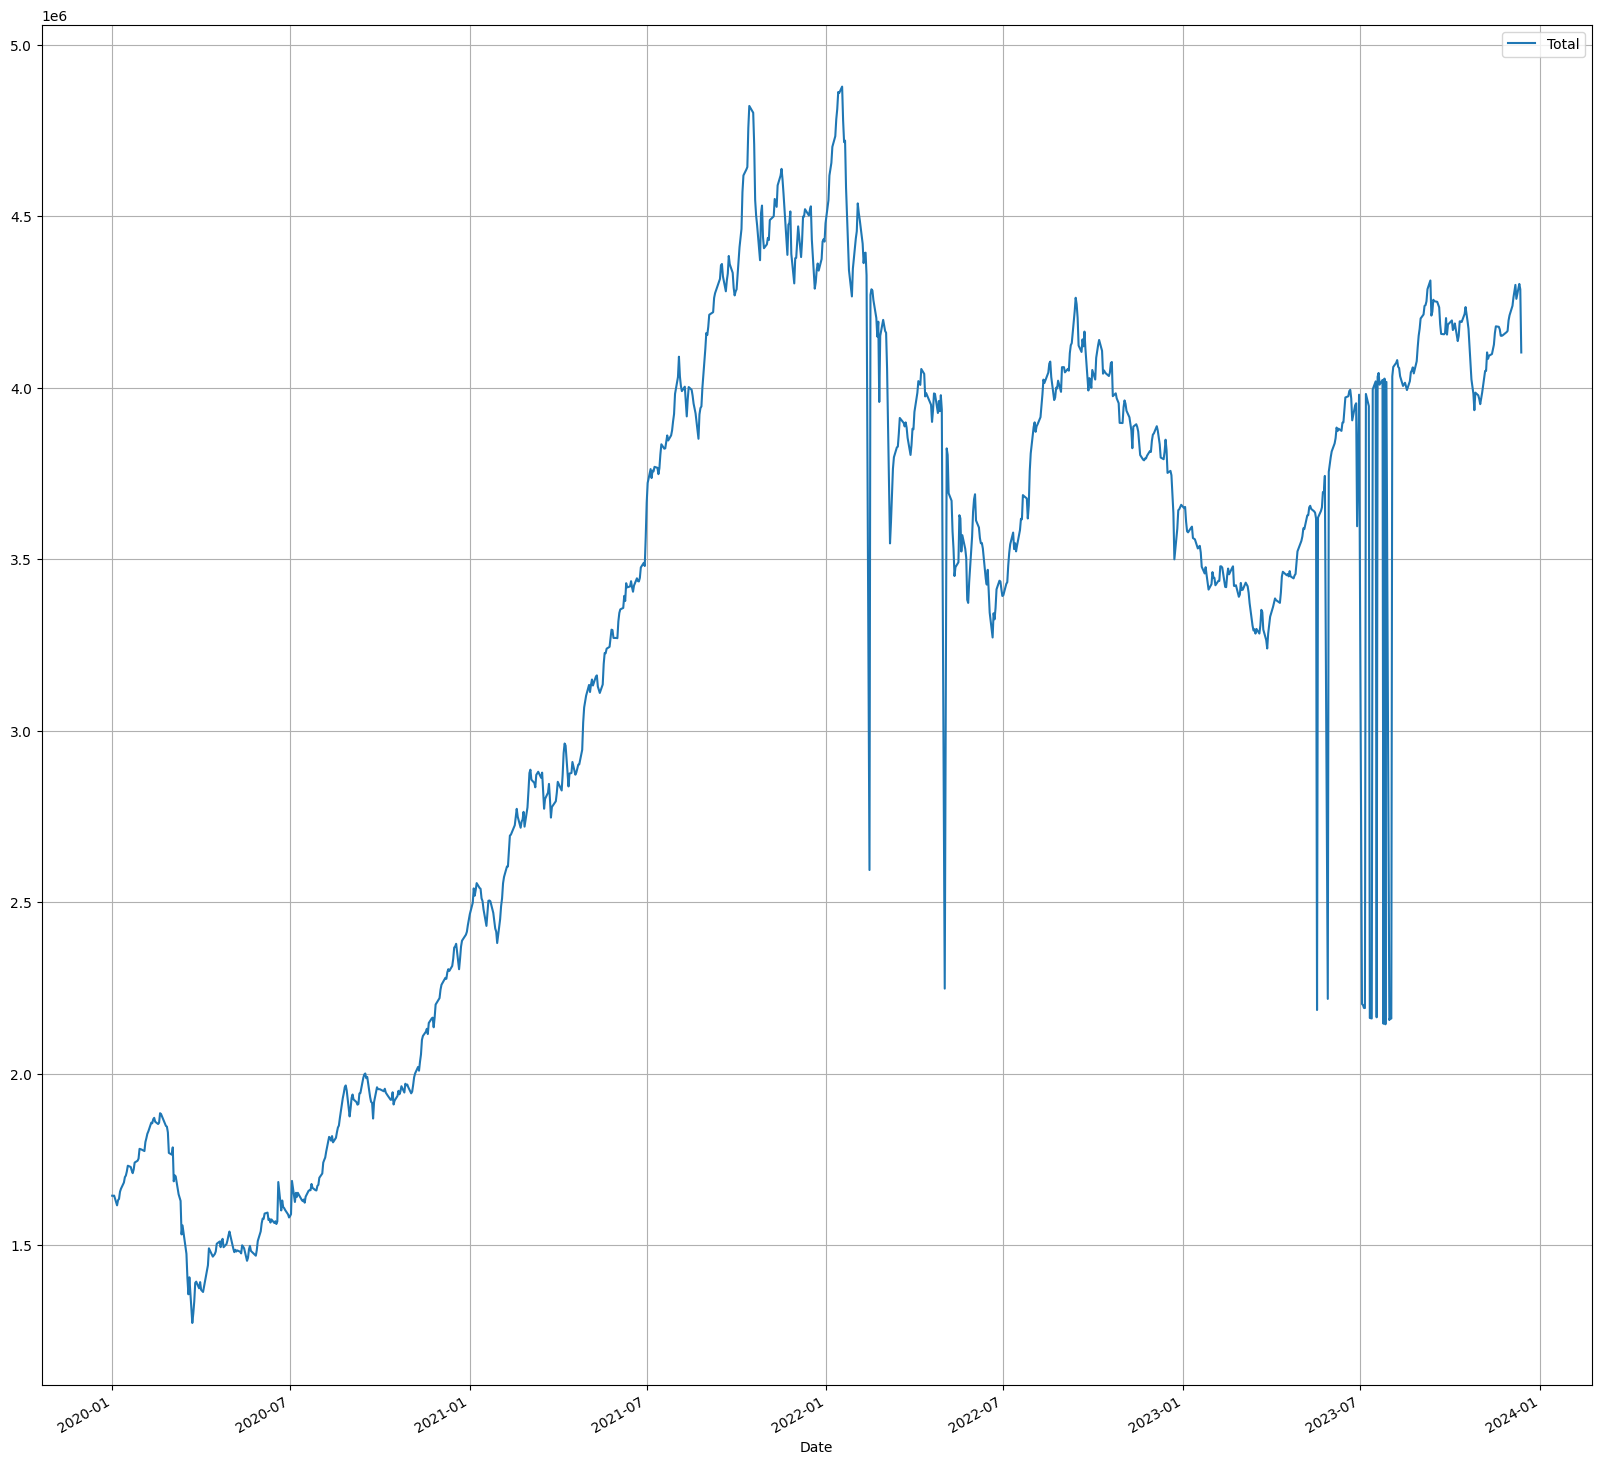

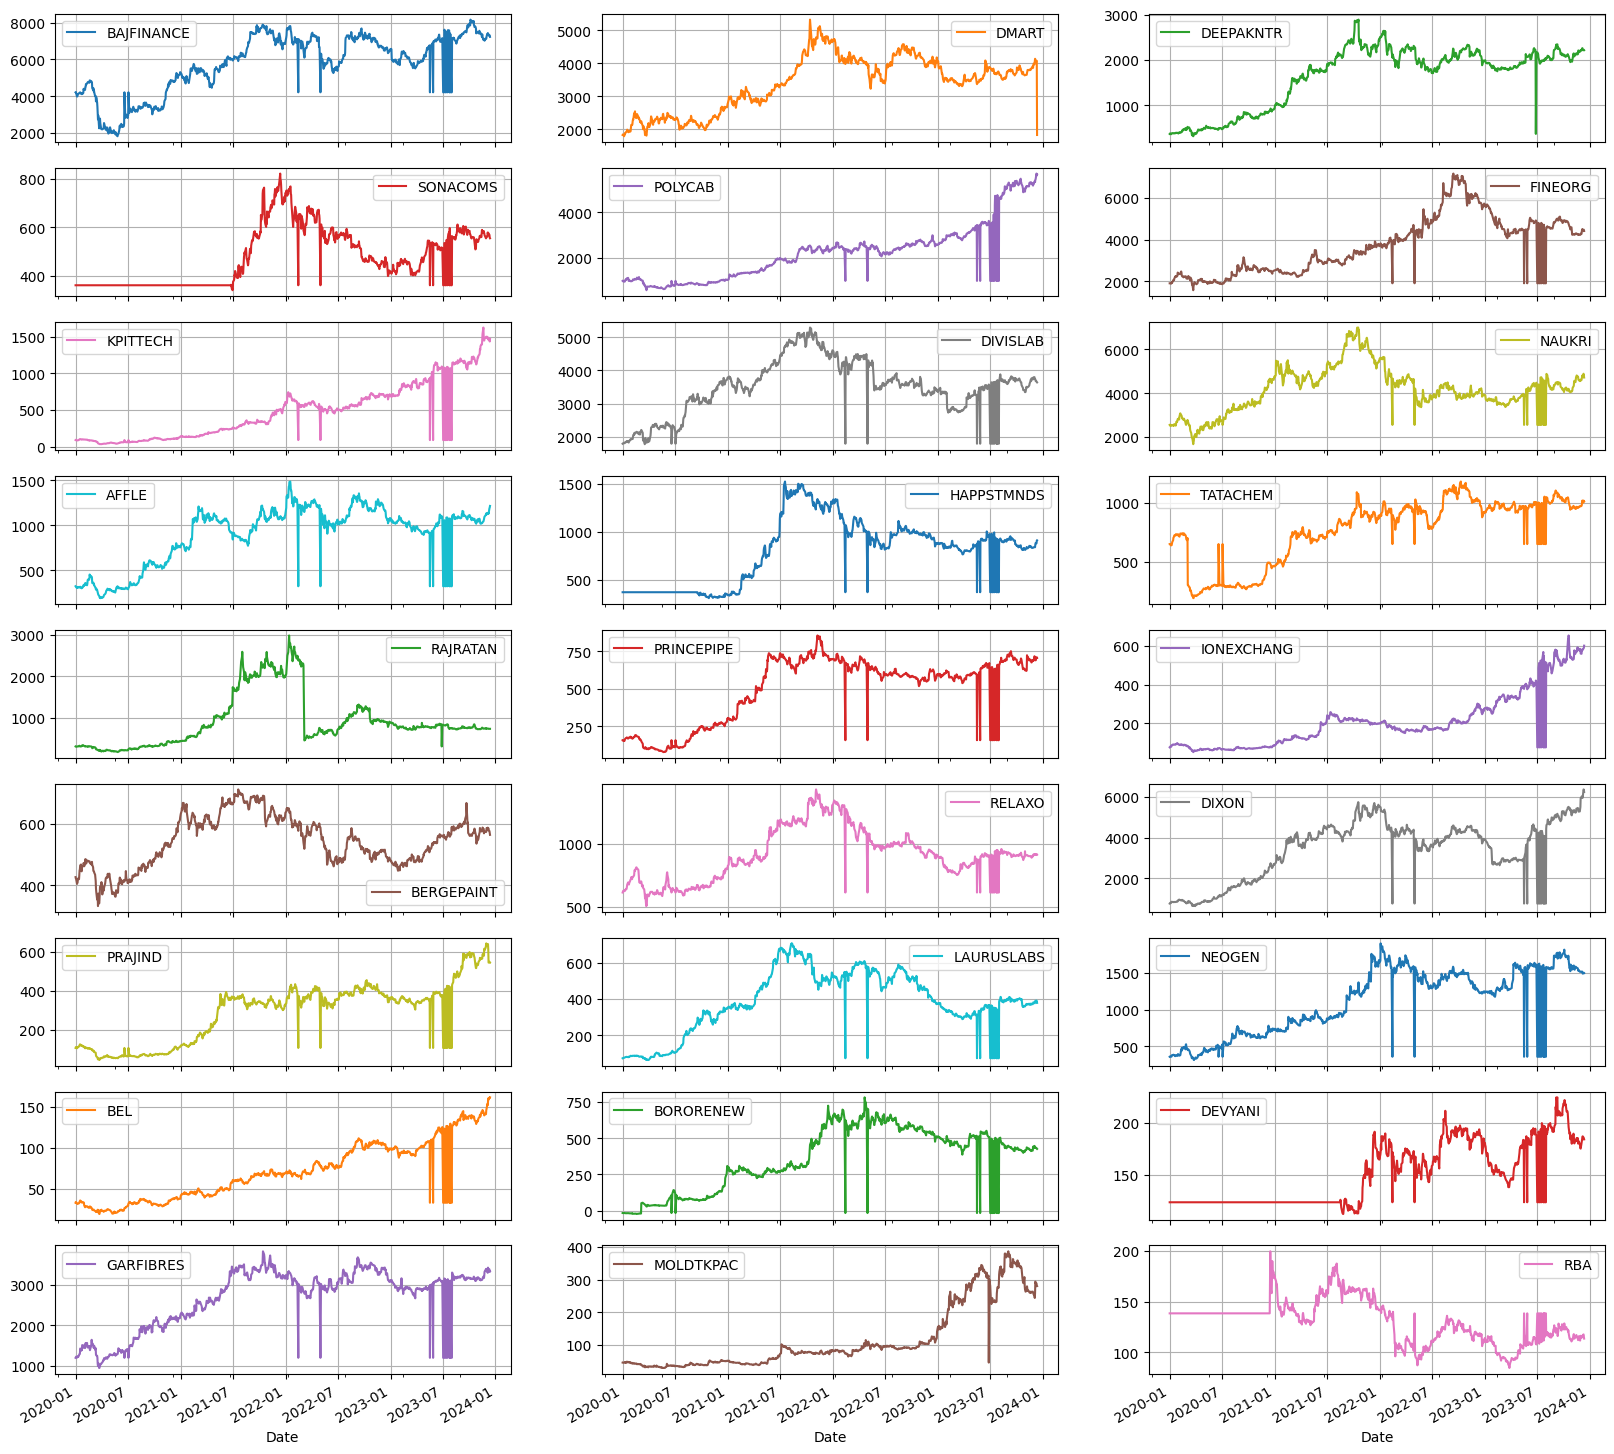

In [9]:

stocks = list(NSE_BSE.values()) # ['BAJFINANCE.BO', 'DMART.NS']

# d = web.DataReader(stocks, 'yahoo', start, end)
# d = data.DataReader("BAJFINANCE.BO",'yahoo', start='2021-09-10', end='2022-10-09')

yfin.pdr_override()

df = pdr.get_data_yahoo(stocks, start=START, end=END, interval=INTERVAL) #['Adj Close']
if INTERVAL == '1wk':
    df = df.asfreq('W-FRI', method='pad')
df = df['Adj Close']
df = df.rename(columns=BSE_NSE)


# df.mean()
# df = df.fillna(df.mean())
# https://stackoverflow.com/questions/42137529/pandas-find-first-non-null-value-in-column
# print(df.loc[~df.isnull().sum(1).astype(bool)].iloc[0]) ### Buggy... HAPPSTMNDS wrong

# Fill first listed value previously for new stocks
df1 = df.fillna(get_first_non_nan(df))

for k in NSE_BSE.keys():
    df1[f'{k}_QTY'] = QTYS[k]

# print(df)

def myfunc(k):
#     print(f"{type(k)}, {k.loc['AFFLE']} ")
    val = 0
    for name in QTYS.keys():
        val += k[name] * k[f'{name}_QTY']
    return val

df['Total'] = df1.apply(myfunc, axis=1)

### Save
save_csv(df)

### Plot Total and all shares
df[['Total']].plot(grid=True, figsize=(20,20))
df1[QTYS.keys()].plot(subplots=True, layout=(9,3), figsize=(20,20), grid=True)

# spy['Close'].values, spy['Close'].index.values
spy.describe()
# dir(spy)
# spy.to_dict()
# spy['Adj Close']

In [142]:
def get_first_non_nan(df):
    df1 = df.fillna('NULL')
    d = dict()
    for s in NSE_BSE.keys():
        for v in df1[s].to_list():
            if v != 'NULL':
                break

        d[s] = v
        
    return pd.Series(d)

# get_first_non_nan(df)

BAJFINANCE    2.894166e+00
DMART         6.169000e+02
DEEPAKNTR     5.240748e+00
SONACOMS      3.637657e+02
POLYCAB       6.325505e+02
FINEORG       8.032501e+02
KPITTECH      1.085042e+02
DIVISLAB      3.632533e+01
NAUKRI        1.389715e+02
AFFLE         1.684700e+02
HAPPSTMNDS    3.573730e+02
TATACHEM      1.023197e+02
RAJRATAN      3.628981e+01
PRINCEPIPE    1.513473e+02
IONEXCHANG    1.003207e+00
BERGEPAINT    3.287313e+00
RELAXO        2.925418e-01
DIXON         5.323333e+02
PRAJIND       7.138882e+00
LAURUSLABS    9.320163e+01
NEOGEN        2.609673e+02
BEL           4.562215e-13
BORORENEW     1.982249e-06
DEVYANI       1.183000e+02
GARFIBRES     3.106511e+01
MOLDTKPAC     2.380550e+00
RBA           1.614500e+02
dtype: float64

#json.dumps(getQuotes('AAPL'), indent=2)
baj = share.Share('BAJFINANCE.BO')

d = baj.get_historical(share.PERIOD_TYPE_WEEK,
                                          3,
                                          share.FREQUENCY_TYPE_WEEK,
                                          1)

# print([datetime.fromtimestamp(x) for x in d['timestamp']])
d

In [130]:
stocks = list(NSE_BSE.values()) # ['BAJFINANCE.BO', 'DMART.NS']
start = dt.datetime(2005, 1, 1)
end = dt.datetime.today() # dt.datetime(2023, 11, 30)
# d = web.DataReader(stocks, 'yahoo', start, end)
# d = data.DataReader("BAJFINANCE.BO",'yahoo', start='2021-09-10', end='2022-10-09')

yfin.pdr_override()

df = pdr.get_data_yahoo(stocks, start=start, end=end, interval='1wk') #['Adj Close']
df = df.asfreq('W-FRI', method='pad')
df = df['Adj Close']
df = df.rename(columns=BSE_NSE)



df['HAPPSTMNDS'].loc[~df.isnull().sum(1).astype(bool)].iloc[0]
df['HAPPSTMNDS']

[*********************100%%**********************]  27 of 27 completed


Date
2005-01-07           NaN
2005-01-14           NaN
2005-01-21           NaN
2005-01-28           NaN
2005-02-04           NaN
                 ...    
2023-10-27    829.500000
2023-11-03    814.744507
2023-11-10    841.549988
2023-11-17    848.000000
2023-11-24    832.349976
Freq: W-FRI, Name: HAPPSTMNDS, Length: 986, dtype: float64

In [131]:
df.head()

,AFFLE,BAJFINANCE,BEL,BERGEPAINT,BORORENEW,DEEPAKNTR,DEVYANI,DIVISLAB,DIXON,DMART,...,NAUKRI,NEOGEN,POLYCAB,PRAJIND,PRINCEPIPE,RAJRATAN,RBA,RELAXO,SONACOMS,TATACHEM
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-07,NaN,2.894166,4.562215e-13,3.287313,0.000002,5.240748,NaN,36.325333,NaN,NaN,...,NaN,NaN,NaN,7.138882,NaN,36.289806,NaN,0.292542,NaN,102.319702
2005-01-14,NaN,2.847183,4.343975e-13,3.184584,0.000002,4.862462,NaN,35.433418,NaN,NaN,...,NaN,NaN,NaN,6.864049,NaN,38.874546,NaN,0.277758,NaN,97.291306
2005-01-21,NaN,2.998704,4.303764e-13,3.433929,0.000002,4.701655,NaN,33.989368,NaN,NaN,...,NaN,NaN,NaN,6.799384,NaN,37.034214,NaN,0.253566,NaN,99.594620
2005-01-28,NaN,3.139653,4.421109e-13,3.712626,0.000002,4.805790,NaN,35.259136,NaN,NaN,...,NaN,NaN,NaN,7.949903,NaN,36.000324,NaN,0.258942,NaN,103.552460
2005-02-04,NaN,3.187811,4.311074e-13,4.354621,0.000002,5.157156,NaN,33.378651,NaN,NaN,...,NaN,NaN,NaN,9.161049,NaN,37.220318,NaN,0.263422,NaN,107.218315
